# TelecomX - Modelo para previnir evasão

## Blibiotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
import seaborn as sns

## Importação dados

In [2]:
dados = pd.read_csv('Dados.csv')
dados['Charges.Total'] = dados['Charges.Total'].replace(r'^\s*$', 0, regex=True)
dados['Charges.Total'] = dados['Charges.Total'].astype("float64")
dados = dados[~dados['Churn'].isna() & (dados['Churn'] != 'nan')]
dados = dados.drop(columns=['Unnamed: 0', 'PaperlessBilling'])
dados = dados[~dados['Churn'].isna() & (dados['Churn'] != 'nan')]


In [3]:
dados_numericos = dados.select_dtypes(include=['number', 'bool'])
correlacao = dados_numericos.corr().abs()
correlacao

,SeniorCitizen,tenure,Charges.Monthly,Charges.Total
SeniorCitizen,1.000000,0.016567,0.220173,0.103006
tenure,0.016567,1.000000,0.247900,0.826178
Charges.Monthly,0.220173,0.247900,1.000000,0.651174
Charges.Total,0.103006,0.826178,0.651174,1.000000


### Tratamento

In [4]:
variaveis = [
    'MultipleLines',
    'InternetService',
    'OnlineSecurity',
    'OnlineBackup',
    'DeviceProtection',
    'TechSupport',
    'StreamingTV',
    'StreamingMovies'
]

for coluna in variaveis:
    print(f"\nFrequência de valores em: {coluna}")
    print(dados[coluna].value_counts())



Frequência de valores em: MultipleLines
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

Frequência de valores em: InternetService
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

Frequência de valores em: OnlineSecurity
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

Frequência de valores em: OnlineBackup
OnlineBackup
No                     3088
Yes                    2429
No internet service    1526
Name: count, dtype: int64

Frequência de valores em: DeviceProtection
DeviceProtection
No                     3095
Yes                    2422
No internet service    1526
Name: count, dtype: int64

Frequência de valores em: TechSupport
TechSupport
No                     3473
Yes                    2044
No internet service    1526
Name: count, dtype: int64

Frequência de valores em: StreamingT

In [5]:
variaveis = [
    'PaymentMethod'

]

for coluna in variaveis:
    print(f"\nFrequência de valores em: {coluna}")
    print(dados[coluna].value_counts())


Frequência de valores em: PaymentMethod
PaymentMethod
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: count, dtype: int64


In [6]:
dadost = dados.copy()

In [7]:
dados_numericos = dadost.select_dtypes(include=['number', 'bool'])
dados_numericos.corr()

,SeniorCitizen,tenure,Charges.Monthly,Charges.Total
SeniorCitizen,1.000000,0.016567,0.220173,0.103006
tenure,0.016567,1.000000,0.247900,0.826178
Charges.Monthly,0.220173,0.247900,1.000000,0.651174
Charges.Total,0.103006,0.826178,0.651174,1.000000


## Encording - Pipeline

In [8]:
y = dadost['Churn']
x = dadost.drop(columns="Churn")
colunas = x.columns

In [9]:
def transformar_dados(x):
    # Contar serviços com "Yes"
    variaveis_internet = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
    x['serviços_internet'] = x[variaveis_internet].apply(lambda linha: sum(valor == 'Yes' for valor in linha), axis=1)
    
    # Criar anos de contrato
    x['anos_contratado'] = x['tenure'].apply(lambda x: x // 12)
    
    return x


# Encapsula a função num transformer
custom_transform = FunctionTransformer(transformar_dados)

transformer = make_column_transformer(
    # Codificação categórica com TargetEncoder
    (OneHotEncoder(), ['gender', 'Partner', 'Dependents', 'Contract',
                       'PaymentMethod', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup',
                       'DeviceProtection', 'TechSupport', 'StreamingTV',
                       'StreamingMovies']),
    
    # Padronização das variáveis numéricas
    (StandardScaler(), ["anos_contratado", 'serviços_internet', 'tenure', 'Charges.Monthly', 'Charges.Total']),
    
    remainder='passthrough'
)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [10]:
def transformaçao(modelo):
    pipeline = make_pipeline(
    custom_transform,        # ← Transformações manuais
    transformer,             # ← ColumnTransformer com TargetEncoder + Scaler
    modelo            # ← Modelo
) 
    return pipeline

## Modelo

### Metricas - **Recall (Revocação)**, **Precisão**, **F1-Score**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(x, y)
# Importando o modelo
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=42, solver='liblinear')
pipeline = transformaçao(log_reg)

# Treinar o modelo com os dados de treino
print("Treinando o modelo de Regressão Logística com solver 'liblinear'...")
pipeline.fit(X_train, y_train)
print("Treinamento concluído!")

# Fazer previsões com os dados de teste
y_pred_log_reg = pipeline.predict(X_test)

Treinando o modelo de Regressão Logística com solver 'liblinear'...
Treinamento concluído!


In [12]:
# Importando o modelo
from sklearn.ensemble import RandomForestClassifier

# Instanciar o modelo
# n_estimators é o número de árvores na floresta
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
pipeline = transformaçao(rf_clf)

# Treinar o modelo com os mesmos dados de treino
print("\nTreinando o modelo de Random Forest...")
pipeline.fit(X_train, y_train)
print("Treinamento concluído!")

# Fazer previsões com os dados de teste
y_pred_rf = pipeline.predict(X_test)


Treinando o modelo de Random Forest...
Treinamento concluído!


In [13]:
# Importando o modelo
from sklearn.tree import DecisionTreeClassifier

# Instanciar o modelo
# n_estimators é o número de árvores na floresta
arvore = DecisionTreeClassifier(random_state=42, max_depth=10)
pipeline = transformaçao(arvore)

# Treinar o modelo com os mesmos dados de treino
print("\nTreinando o modelo de Random Forest...")
pipeline.fit(X_train, y_train)
print("Treinamento concluído!")

# Fazer previsões com os dados de teste
y_pred_arvore = pipeline.predict(X_test)


Treinando o modelo de Random Forest...
Treinamento concluído!


# Avaliação do modelo

In [14]:
def confusao(y, y_pred, i):
    matriz = confusion_matrix(y, y_pred)
    # Visualizar com heatmap
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Greens',
        xticklabels = ['VN', 'FP'],
        yticklabels = ['FN', 'VF']      
        )
    plt.title(f'Matriz de Confusão da {i}')
    plt.show()
    
def gerar_metricas(nome, modelo, X_test, y_test, y_pred):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    cm_str = f"[[{cm[0][0]}, {cm[0][1]}], [{cm[1][0]}, {cm[1][1]}]]"

    return {
        'Modelo': nome,
        'Acurácia': accuracy_score(y_test, y_pred),
        'Precisão': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'Matriz de Confusão': cm_str
    }

# Coletar métricas de todos os modelos
resultados = [
    gerar_metricas("Regressão Logística", log_reg, X_test, y_test, y_pred_log_reg),
    gerar_metricas("Random Forest", rf_clf, X_test, y_test, y_pred_rf),
    gerar_metricas("Árvore de Decisão", arvore, X_test, y_test, y_pred_arvore)
]
# Criar DataFrame
resultados = pd.DataFrame(resultados)
resultados = resultados.sort_values(by='F1-Score', ascending=False)

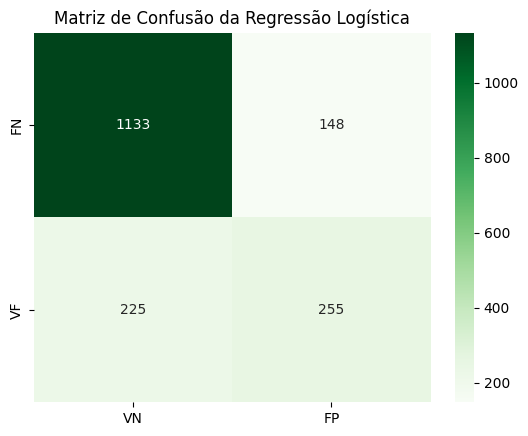

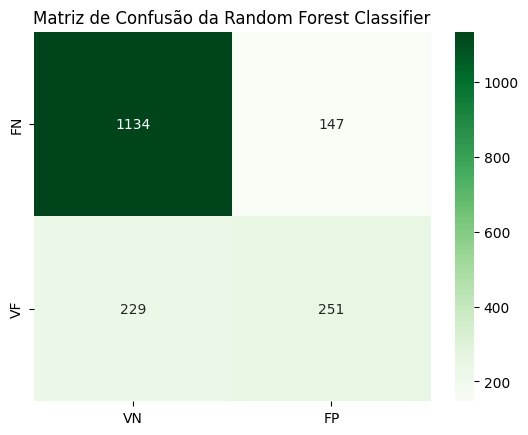

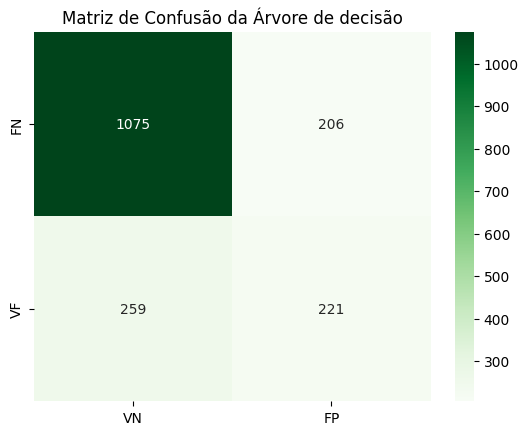

,Modelo,Acurácia,Precisão,Recall,F1-Score,Matriz de Confusão
0,Regressão Logística,0.788189,0.632754,0.531250,0.577576,"[[1133, 148], [225, 255]]"
1,Random Forest,0.786485,0.630653,0.522917,0.571754,"[[1134, 147], [229, 251]]"
2,Árvore de Decisão,0.735945,0.517564,0.460417,0.487321,"[[1075, 206], [259, 221]]"


In [15]:
confusao(y_test, y_pred_log_reg, "Regressão Logística")
confusao(y_test, y_pred_rf, "Random Forest Classifier")
confusao(y_test, y_pred_arvore, "Árvore de decisão")
resultados

## Modelo escolhido foi **Regressão logistica**

### esse modelo foi escolhido devido a seus metricas **Acurácia: 0.80**, **Precisão: 0.64**, **Recall: 0.53**, **F1-Score: 0.58** 
- O modelo Random Forest, apesar de ter boa acurácia (79,27%), apresentou desempenho inferior na métrica recall, mostrando-se menos eficaz para o problema específico.
- O modelo de Ávore de Decisão, apesar de ter uma acurácia de (75,80%), apresentou desempenho inferior na métricas de recall, F1-Score e precisão, mostrando-se menos eficaz para o problema específico.

